# Software 2.0 with `JAX`
**Demonstrating Differentiable Physics with Ballistic Motion**

<a target="_blank" href="https://colab.research.google.com/github/JeremyPohly/diffphys/blob/main/ballistics.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import jax
import jax.numpy as jnp
from jax import lax, grad

## Background
 
XX
 

## General Equations of Motion
 
$$
\begin{align}
    \ddot{x} = -C_d^* v \dot{x} \\
    \ddot{y} = -g - C_d^* v \dot{y}
\end{align}
$$
 
where 
 

In [2]:
class BallisticStepper:
    g = 9.81
    dt = 0.01
    def __init__(self, cd=0.0):
        self.cd = cd

    def eoms(self, state):
        cd = self.cd
        g = BallisticStepper.g

        x, y, x_dot, y_dot = state
        v_mag = jnp.sqrt(x_dot**2 + y_dot**2)
        x_ddot = -cd * v_mag * x_dot
        y_ddot = -g - cd * v_mag * y_dot

        return jnp.array([x_dot, y_dot, x_ddot, y_ddot])

    def integrate(self, state):
        return state + BallisticStepper.dt*self.eoms(state)

    def __call__(self, state):
        return self.integrate(state)

def rollout(stepper, n_steps: int, include_init: bool = False):
    """
    Roll out the dynamics over a given time array.

    Args:
        stepper: Function to compute the next state, accepts (state).
        time_array: Array of time points.
        include_init: Whether to include the initial state in the trajectory.

    Returns:
        Trajectory of states as a JAX array.
    """
    def scan_fn(carry, _):
        state, done = carry
        next_state = stepper(state)
        new_done = jnp.logical_or(done, next_state[1] < 0.0)
        next_state = jnp.where(done, state, next_state)
        return (next_state, new_done), next_state 

    def rollout_fn(state_init):
        init_done = False
        (final_state, _), trj = jax.lax.scan(scan_fn, (state_init, init_done),
            xs=None, length=n_steps)

        if include_init:
            return jnp.concatenate(
                [jnp.expand_dims(state_init, axis=0), trj], axis=0)

        return trj

    return jax.jit(rollout_fn)

def calc_vac_xf(theta, v, g):
    return v**2 * jnp.sin(2*theta) / g

stepper_vac = BallisticStepper(cd=0.0)
stepper_atm = BallisticStepper(cd=0.001)

n_steps = 5_000
v_mag_0 = 100.0
theta_0 = jnp.deg2rad(45.0)
x_dot_0 = v_mag_0 * jnp.cos(theta_0)
y_dot_0 = v_mag_0 * jnp.sin(theta_0)

# Construct the initial state:
state_0 = jnp.array([0.0, 0.0, x_dot_0, y_dot_0])

trj_vac = rollout(stepper_vac, n_steps, include_init=True)(state_0)
trj_atm = rollout(stepper_atm, n_steps, include_init=True)(state_0)

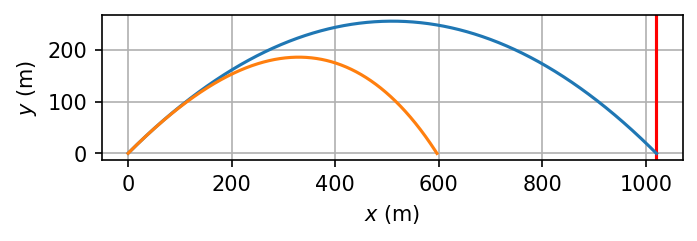

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5), dpi=150)
ax = fig.add_subplot(111)
ax.set_aspect("equal")

ax.axvline(calc_vac_xf(theta_0, v_mag_0, 9.81), c='r')
ax.plot(trj_vac[:,0], trj_vac[:,1], label="vacuum")
ax.plot(trj_atm[:,0], trj_atm[:,1], label="quadratic drag")
ax.set_xlabel(r"$x$ (m)")
ax.set_ylabel(r"$y$ (m)")
ax.grid()
